In [1]:
import numpy as np
import heapq

In [2]:
#解码数据集 函数为CIFAR-10提供的python3版本
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#创建训练集和测试集
def CreatData(path):
    #依次加载CIFAR-10的5个batch_data,并将其合并为traindata和traindlabels
    x=[]
    y=[]
    for i in range(1,6):
        batch_path=path + 'data_batch_%d'%(i) #每个batch的地址
        batch_dict=unpickle(batch_path) #解码每个batch
        train_batch=batch_dict[b'data'].astype('float') #将每个batch的data部分以float形式存储于train_batch变量
        train_labels=np.array(batch_dict[b'labels']) #将每个batch的label部分以np.array的形式存储于train_labels变量
        x.append(train_batch)
        y.append(train_labels)
    #将5个训练样本batch(10000,3072)合并为(50000,3072)，标签合并为(50000,1)
    #np.concatenate默认axis=0:按行合并，axis=1则为:按列合并
    traindata=np.concatenate(x)
    trainlabels=np.concatenate(y)
    
    #加载测试集
    testpath=path + 'test_batch' #test_batch的地址
    test_dict=unpickle(testpath) #解码test_batch
    testdata=test_dict[b'data'].astype('float') #将test_dict的data部分以float形式存储于testdata变量
    testlabels=np.array(test_dict[b'labels']) #将test_dict的labels部分以np.array形式存储于testlabels变量
    
    #将训练集数据、训练集标签、测试集数据、测试集标签返回
    return traindata,trainlabels,testdata,testlabels

#分出一个含1000张图片的验证集
def split_validationset(traindata,trainlabels):
    validationdata = traindata[:1000, :]
    validationlabels = trainlabels[:1000]
    traindata = traindata[1000:, :]
    trainlabels = trainlabels[1000:]
    return traindata,trainlabels,validationdata,validationlabels

class NearestNeighborClassifier:
    def __init__(self):
        pass
    def train(self,traindata,trainlabels):
        #将traindata和trainlabels全部读取到类里面
        self.traindata = traindata
        self.trainlabels = trainlabels
 
    def predict(self,testdata,k):
        #得到测试集总图片数，并保存到testimg_num内
        testimg_num = testdata.shape[0]
        #创建一个维度为(testimg_num，)的np.array，用于存储预测的标签
        predlabels = np.zeros(testimg_num, dtype = self.trainlabels.dtype)
        predtemp = np.zeros(k, dtype = self.trainlabels.dtype)
        #遍历训练集
        for i in range(testimg_num):
            #计算测试图片与训练集中所有图片的l1距离，并找到最近的图片
            distances = np.sum(np.abs(self.traindata - testdata[i,:]),axis = 1)#axis=0:列求和 axis=1:行求和
            mindistances_index = list(map(list(distances).index, heapq.nsmallest(k, distances))) #取最近k张图片的下标
            #heapq.nlargest(k, distances)返回distances最小的k个元素
            #map(list(distances).index, heapq.nsmallest(k, distances))则返回distances最小的k个元素对应的索引，调用list.index()函数来寻找
            #mindistances_index最终以list形式储存最近的k张图片的索引
            
            #将最近的k张图片所对应的标签存储于predtemp中
            for j in range(k):
                predtemp[j] = self.trainlabels[mindistances_index[j]]
            predlabels[i] = np.argmax(np.bincount(np.uint(predtemp))) #记录下出现次数最多的标签，作为预测的标签
            #np.bincount(x)统计x内0到max(x)中每个整数出现的次数
        #返回预测标签
        return predlabels

In [7]:
#读取训练集和测试集的数据和标签
traindata,trainlabels,testdata,testlabels = CreatData("D:/Personal_documents/DXY/code/LearningForML/cifar-10-batches-py/")
#分理处验证集
traindata,trainlabels,validationdata,validationlabels = split_validationset(traindata,trainlabels)
#实例化一个最近邻分类的类
nn = NearestNeighborClassifier()
#调用类中的train函数训练(实则为将训练数据全部读取)
nn.train(traindata, trainlabels)

knum = 10 #设置总共比对多少个超参数k的结果
accuracy = np.zeros(knum) #将每个超参数k的结果存储
for i in range(knum):
    #调用类中的predict函数预测标签
    validationlabels_predict = nn.predict(validationdata,2 * i + 1)
    #比对验证集标签，计算准确率。
    accuracy[i] = np.mean(validationlabels_predict == validationlabels)

k = np.argmax(accuracy) * 2 + 1 #得到准确率最高的k值
testlabels_predict = nn.predict(testdata,k) #预测测试集标签
print('accuracy:',np.mean(testlabels_predict == testlabels))

accuracy: 0.3753


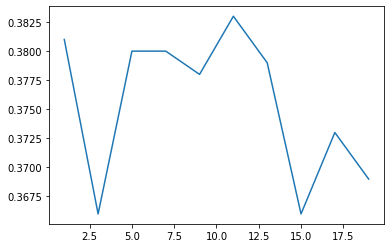

In [8]:
#不同k值的准确率
import matplotlib.pyplot as plt
x = np.zeros(knum)
for i in range(knum):
    x[i] = 2 * i + 1
plt.plot(x,accuracy)